In [1]:
## Author: Clay Crews
# 01/31/2025
## This code trains a PINN only on physics-based loss
#   The trained model makes predictions on the training data to show model fit.
#   Not much testing done on generalization of model.

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.nn.init as init

import numpy as np

from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split


# # Set the seed for general torch operations
# torch.manual_seed(37)
# # Set the seed for CUDA torch operations (ones that happen on the GPU)
# torch.cuda.manual_seed(37)

In [3]:
# Gen PWM function
def gen_pwm(sample_rate, pwm_frequency, duty_cycle, time):
    # PWM period
    pwm_period_in_cycles = int(np.floor(sample_rate / pwm_frequency))
    
    # Set up PWM signal
    pwm_signal = np.ones_like(time)
    for i in range(0, len(time) - 1, pwm_period_in_cycles):
        current_duty_cycle = duty_cycle[i]
        
        for j in range(pwm_period_in_cycles):
            on_time = pwm_period_in_cycles * current_duty_cycle
            if j < on_time:
                pwm_value = 1
            else:
                pwm_value = 0
            pwm_signal[i + j] = pwm_value
            
    return pwm_signal

In [4]:
# Simulation settings
sample_rate = 1e6   # 1 MHz
time_span = 120e-3  # 120 ms
period = 120e-3     # control period (time from .5 to 1 to 0)
pwm_frequency = 1e4 # 10 KHz
# pwm_update_ratio = 1000

# Converter settings
L = 1e-2
C = 1e-5
V_i = 10
R = 10


# PINN settings
epsilon = 1e-6

# time scale
time = np.arange(0, time_span + 1/sample_rate, 1/sample_rate)

# R = (np.sin(2 * np.pi / period * time) + 1) / 2

# Allocate memory
time_length = len(time)
i_L_0 = np.ones(time_length)
V_o_0 = np.ones(time_length)
i_L_solver = np.ones(time_length)
V_o_solver = np.ones(time_length)
d = np.zeros(time_length)

# Training parameters
num_epochs = 100
mini_batch_size = time_length 
learn_rate = 0.0003
# learn_rate = 0.001


# Timestep
delta_t = 1 / sample_rate

# Stimulus
duty_cycle = (np.sin(2 * np.pi / period * time) + 1) / 2
# duty_cycle = np.full(time_length, 0.5)


# #####
# # Make sure we create a duty cycle array of exactly the right length
# quarter_length = time_length // 4  # Use integer division
# remainder = time_length % 4  # Get any remaining points
# # Create base arrays
# duty_cycle_2 = np.full(quarter_length, 1)
# duty_cycle_1 = np.full(quarter_length, 0)
# duty_cycle_4 = np.full(quarter_length, 1)
# duty_cycle_3 = np.full(quarter_length + remainder, 0)  # Add remainder to last segment
# # Concatenate
# duty_cycle = np.concatenate([duty_cycle_1, duty_cycle_2, duty_cycle_3, duty_cycle_4])
# #####


# duty_cycle = np.zeros_like(time)
# for i in range(time_length):
#     duty_cycle[i] = 0.5

# Assuming `gen_pwm` is a custom function to generate PWM signals
# You need to implement this function or use an alternative method to generate PWM signals
# pwm_signal = gen_pwm(sample_rate, pwm_frequency, duty_cycle, time)

# Initial conditions
i_L = np.ones_like(time)
V_o = np.ones_like(time)

In [5]:
# # Simulate with Runge-Kutta

# # Define the system of differential equations
# def eq(t, y):
#     i_L, V_o = y
#     pwm_index = int(round(t * sample_rate))
#     pwm_value = pwm_signal[pwm_index] if pwm_index < len(pwm_signal) else 0
#     di_L_dt = 0 - (1 / L) * V_o
#     dV_o_dt = (1 / C) * i_L - (1 / (R[0] * C)) * V_o + (pwm_value * V_i) / L
#     return [di_L_dt, dV_o_dt]

# # Initial conditions
# initial_conditions = [i_L[0], V_o[0]]

# # Solve the differential equations using RK4
# sol = solve_ivp(eq, [0, time_span], initial_conditions, method='RK45', t_eval=time)

# # Plot the results
# plt.figure()
# plt.plot(time, sol.y[0], label='RK current')
# plt.plot(time, sol.y[1], label='RK voltage')
# plt.ylabel('volts/amps')
# plt.xlabel('time (s)')
# plt.legend()
# plt.title('Runge-Kutta solver')
# plt.twinx()
# plt.plot(time, duty_cycle, 'g', label='PWM')
# plt.ylabel('duty cycle')
# plt.ylim(0, 1)
# plt.legend(loc='lower right')
# plt.show()


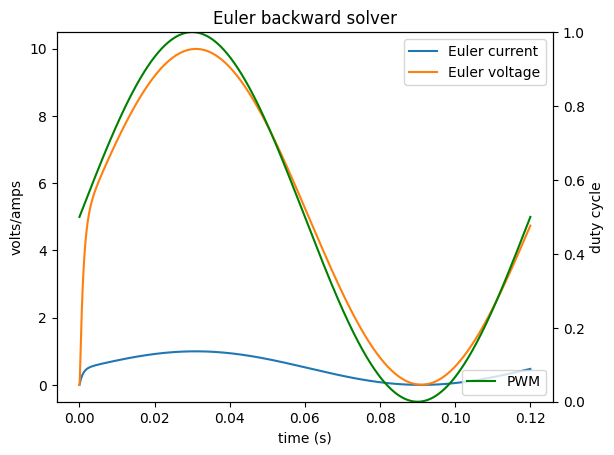

In [6]:
# Simulate with Euler Backwards

# Initialize arrays
i_L_solver = np.zeros_like(time)
V_o_solver = np.zeros_like(time)

# Initialize previous solutions
i_L_0 = np.copy(i_L_solver)
V_o_0 = np.copy(V_o_solver)

# ct = 1

# Implement Euler backward solver
for i in range(1, len(time)):
    # Left-hand side matrix
    LHS = np.array([[1, delta_t / L], [-delta_t / C, delta_t / (C * R) + 1]])
    # LHS = np.array([[1, delta_t / L], [-delta_t / C, delta_t / (C * R[i]) + 1]])
    
    # Right-hand side vector
    RHS = np.array([delta_t * duty_cycle[i] * V_i / L + i_L_solver[i - 1], V_o_solver[i - 1]])
    
    # Solve for the next step
    solved = np.linalg.solve(LHS, RHS)
    i_L_solver[i] = solved[0]
    V_o_solver[i] = solved[1]
    
    # Update initial conditions if PWM signal changes
    if duty_cycle[i] != duty_cycle[i - 1]:
        i_L_0[i] = i_L_solver[i - 1]
        V_o_0[i] = V_o_solver[i - 1]
    else:
        i_L_0[i] = i_L_0[i - 1]
        V_o_0[i] = V_o_0[i - 1]

    # if ct == pwm_update_ratio:
    #     ct = 0
    #     i_L_0[i] = i_L_solver[i - 1]
    #     V_o_0[i] = V_o_solver[i - 1]
    # else:
    #     i_L_0[i] = i_L_0[i - 1]
    #     V_o_0[i] = V_o_0[i - 1]

    # ct += 1

# Set up training data
train_input = np.vstack([duty_cycle, i_L_0, V_o_0, time])
# train_input = np.vstack([i_L_0, V_o_0, time])

# Plot results for sanity check
plt.figure()
plt.plot(time, i_L_solver, label='Euler current')
plt.plot(time, V_o_solver, label='Euler voltage')
plt.ylabel('volts/amps')
plt.xlabel('time (s)')
plt.legend()
plt.twinx()
plt.plot(time, duty_cycle, 'g', label='PWM')
plt.ylabel('duty cycle')
plt.ylim(0, 1)
plt.legend(loc='lower right')
plt.title('Euler backward solver')
plt.show()





In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
input_features = train_input.T
output_labels = np.vstack([i_L_solver, V_o_solver]).T



# from sklearn.preprocessing import StandardScaler
# input_scaler = StandardScaler()
# input_normalized = input_scaler.fit_transform(input_features)


# output_scaler = StandardScaler()
# output_normalized = output_scaler.fit_transform(output_labels)




# Convert to PyTorch tensors
inputs = torch.tensor(input_features, dtype=torch.float32)
labels = torch.tensor(output_labels, dtype=torch.float32)

# Check shapes
print("Input features shape:", inputs.shape)
print("Output labels shape:", labels.shape)


# Create DataLoader
dataset = TensorDataset(inputs, labels)
dataloader = DataLoader(dataset, batch_size=mini_batch_size, shuffle=True)


duty_cycle_data = duty_cycle.T
# duty_cycle_tensor = torch.tensor(duty_cycle_data, dtype=torch.float32).to(device)

# R = R.T
# R = torch.tensor(R, dtype=torch.float32).to(device)


Input features shape: torch.Size([120001, 4])
Output labels shape: torch.Size([120001, 2])


In [9]:
# from torch.utils.data.dataset import random_split

# # Define the sizes of the training and validation sets
# train_size = int(0.8 * len(dataset))  # 80% of the data for training
# val_size = len(dataset) - train_size  # Remaining 20% for validation

# # Split the dataset into training and validation sets
# train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# # Create DataLoaders for training and validation sets
# train_dataloader = DataLoader(train_dataset, batch_size=train_size, shuffle=True)
# val_dataloader = DataLoader(val_dataset, batch_size=val_size)


In [10]:
# Make a random set of data to train on



In [11]:
# # Set up Buck Converter NN

# class BuckConverterNN(nn.Module):
#     def __init__(self):
#         super(BuckConverterNN, self).__init__()
#         self.layers = nn.Sequential(
#             nn.Linear(4, 50),
#             nn.LayerNorm(50),
#             nn.Sigmoid(),
#             nn.Linear(50, 50),
#             nn.LayerNorm(50),
#             nn.Sigmoid(),
#             nn.Linear(50,50),
#             nn.LayerNorm(50),
#             nn.Sigmoid(),
#             nn.Linear(50, 2)
#         )

#         # self.epsilon = torch.finfo(torch.float32).eps

#     def forward(self, x):
#         # Apply log activation function with epsilon for numerical stability
#         x = torch.log(epsilon + x)
#         return self.layers(x)
    
# model = BuckConverterNN().to(device)


### Use with L-BFGS optimizer
class BuckConverterNN(nn.Module):
    def __init__(self):
        super(BuckConverterNN, self).__init__()

        ## NOTE: 
        # The GELU layers converge faster !!
        # The Tanh is more stable in training (no exploding or NAN gradients)...

        # self.layers = nn.Sequential(
        #     nn.Linear(4, 50),
        #     nn.GELU(),
        #     nn.Linear(50, 50),
        #     nn.GELU(),
        #     nn.Linear(50,50),
        #     nn.GELU(),
        #     nn.Linear(50,50),
        #     nn.GELU(),
        #     nn.Linear(50, 2)
        # )
        self.layers = nn.Sequential(
            nn.Linear(4, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 2)
        )

    def forward(self, x):
        return self.layers(x)
    

    def physics_loss(self, inputs):
        # X[0] = d
        # X[1] = i_L_0
        # X[2] = V_o_0
        # X[3] = t

        # Pass through the network
        Y = self(inputs)

        X = inputs



        ###

        di_L_dt = torch.autograd.grad(outputs=torch.sum(Y[:,0]), inputs=X, create_graph=True)[0]
        dV_o_dt = torch.autograd.grad(outputs=torch.sum(Y[:,1]), inputs=X, create_graph=True)[0]

        ode_i_L = (-Y[:, 1] / L) + ((X[:,0] * V_i) / L)
        ode_V_o = (Y[:, 0] / C) - (Y[:, 1] / (R * C))


        loss_i_L = F.mse_loss(ode_i_L, di_L_dt[:,3])
        loss_V_o = F.mse_loss(ode_V_o, dV_o_dt[:,3])


        ## Accidently left wrt V_o... same results than wrt time. Why?
        # loss_i_L = F.mse_loss(ode_i_L, di_L_dt[:,2])
        # loss_V_o = F.mse_loss(ode_V_o, dV_o_dt[:,2])

        
        


        ## Adding initial condition loss gives generally same results as without
        # Initial condition loss
        X_at_time_0 = X.clone()
        X_at_time_0[:,3] = 0
        Y0 = self(X_at_time_0)
        loss_i_L_0 = F.mse_loss(Y0[:,0], X[:,1])
        loss_V_o_0 = F.mse_loss(Y0[:,1], X[:,2])
        # init_cond_0 = torch.zeros_like(X[:,1])
        # loss_i_L_0 = F.mse_loss(Y0[:,0], init_cond_0)
        # loss_V_o_0 = F.mse_loss(Y0[:,1], init_cond_0)


        loss = loss_i_L + loss_V_o + loss_i_L_0 + loss_V_o_0

        return loss


    
model = BuckConverterNN().to(device)






In [12]:


# ### Use with L-BFGS optimizer
# class BuckConverterNN(nn.Module):
#     def __init__(self):
#         super(BuckConverterNN, self).__init__()
#         self.layers = nn.Sequential(
#             nn.Linear(4, 50),
#             nn.GELU(),
#             nn.Linear(50, 50),
#             nn.GELU(),
#             nn.Linear(50,50),
#             nn.GELU(),
#             nn.Linear(50,50),
#             nn.GELU(),
#             nn.Linear(50, 2)
#         )
#     def forward(self, x):
#         return self.layers(x)
# model = BuckConverterNN().to(device)






#### Use with Adam optimizer
# class BuckConverterNN(nn.Module):
#     def __init__(self):
#         super(BuckConverterNN, self).__init__()
#         self.layers = nn.Sequential(
#             nn.Linear(4, 50),
#             nn.GELU(),
#             nn.Linear(50, 50),
#             nn.GELU(),
#             nn.Linear(50,50),
#             nn.GELU(),
#             nn.Linear(50,50),
#             nn.GELU(),
#             nn.Linear(50, 2)
#             nn.Linear(2, 2) # scaling layer -- best, only with R=1 !!!??
#         )
#         # Initialize the weights of the scaling layer -- best, only with R=1 !!!?? 
#         self.layers[-1].weight.data.fill_(100)  # Set the weights to 10 (set to V_i ??)
#     def forward(self, x):
#         return self.layers(x)
# model = BuckConverterNN().to(device)










# class BuckConverterNN(nn.Module):
#     def __init__(self):
#         super(BuckConverterNN, self).__init__()
#         self.layers = nn.Sequential(
#             nn.Linear(3, 128),
#             nn.ReLU(),
#             nn.Linear(128, 2),
#             nn.Linear(2,2)
#         )
#         self.layers[-1].weight.data.fill_(100)

#     def forward(self, x):
#         return self.layers(x)

    
# model = BuckConverterNN().to(device)



# class BuckConverterNN(nn.Module):
#     def __init__(self):
#         super(BuckConverterNN, self).__init__()
#         self.layers = nn.Sequential(
#             nn.Linear(4, 50),
#             nn.LayerNorm(50),  # Add layer normalization
#             nn.Sigmoid(),
#             nn.Dropout(p=0.5),  # Dropout layer with dropout probability of 0.5
#             nn.Linear(50, 50),
#             nn.LayerNorm(50),  # Add layer normalization
#             nn.Sigmoid(),
#             nn.Dropout(p=0.5),  # Dropout layer with dropout probability of 0.5
#             nn.Linear(50, 50),
#             nn.LayerNorm(50),  # Add layer normalization
#             nn.Sigmoid(),
#             nn.Dropout(p=0.5),  # Dropout layer with dropout probability of 0.5
#             nn.Linear(50, 2)
#         )

#     def forward(self, x):

#         # x = torch.log(epsilon + x)
#         return self.layers(x)

# model = BuckConverterNN().to(device)

In [13]:
# # Define your neural network model
# class MyModel(nn.Module):
#     def __init__(self, input_size, output_size):
#         super(MyModel, self).__init__()
#         self.fc1 = nn.Linear(input_size, 64)
#         self.fc2 = nn.Linear(64, output_size)

#     def forward(self, x):
#         x = torch.relu(self.fc1(x))
#         x = self.fc2(x)
#         return x
    
# model = MyModel(4, 2).to(device)





In [14]:
# Define optimizer
# optimizer = optim.Adam(model.parameters(), lr=learn_rate)

# Define learning rate scheduler
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.1)

# Define loss function
# criterion = nn.MSELoss()  

In [15]:
## This sucessfully trains for data

# Now do with physics equations

In [16]:
## Physics loss moved to inside network class -- moved inside network class
# import torch.nn.functional as F

# def physics_loss(inputs, model):
#     # X[0] = d
#     # X[1] = i_L_0
#     # X[2] = V_o_0
#     # X[3] = t

#     # Pass through the network
#     Y = model(inputs)

#     X = inputs



#     ###

#     di_L_dt = torch.autograd.grad(outputs=torch.sum(Y[:,0]), inputs=X, create_graph=True)[0]
#     dV_o_dt = torch.autograd.grad(outputs=torch.sum(Y[:,1]), inputs=X, create_graph=True)[0]

#     ode_i_L = (-Y[:, 1] / L) + ((X[:,0] * V_i) / L)
#     ode_V_o = (Y[:, 0] / C) - (Y[:, 1] / (R * C))


#     loss_i_L = F.mse_loss(ode_i_L, di_L_dt[:,3])
#     loss_V_o = F.mse_loss(ode_V_o, dV_o_dt[:,3])


#     ## Accidently left wrt V_o... same results than wrt time. Why?
#     # loss_i_L = F.mse_loss(ode_i_L, di_L_dt[:,2])
#     # loss_V_o = F.mse_loss(ode_V_o, dV_o_dt[:,2])

    
    


#     ## Adding initial condition loss gives generally same results as without
#     # Initial condition loss
#     X_at_time_0 = X.clone()
#     X_at_time_0[:,3] = 0
#     Y0 = model(X_at_time_0)
#     loss_i_L_0 = F.mse_loss(Y0[:,0], X[:,1])
#     loss_V_o_0 = F.mse_loss(Y0[:,1], X[:,2])
#     # init_cond_0 = torch.zeros_like(X[:,1])
#     # loss_i_L_0 = F.mse_loss(Y0[:,0], init_cond_0)
#     # loss_V_o_0 = F.mse_loss(Y0[:,1], init_cond_0)


#     loss = loss_i_L + loss_V_o + loss_i_L_0 + loss_V_o_0

#     return loss



In [ ]:
optimizer = optim.LBFGS(model.parameters(), lr=0.1)

num_epochs = 300

prev_loss = 0

def closure():
    optimizer.zero_grad()
    loss = model.physics_loss(inputs) 
    loss.backward()
    return loss

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(dataloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)  # Move data to device

        inputs = inputs.requires_grad_(True)

        # Compute the loss
        loss = closure()
        running_loss += loss.item()

        # Check for NaN in gradients
        for name, param in model.named_parameters():
            if param.grad is not None and torch.isnan(param.grad).any():
                print(f"NaN detected in gradients of {name} at epoch {epoch+1}")
                break

    if prev_loss == 0:
        prev_loss = running_loss            
    # Check for NaN in loss 
    if torch.isnan(loss).any():
        print(f"NaN detected in loss at epoch {epoch+1}")
        break        
    elif torch.isinf(loss).any():
        print(f"inf detected in loss at epoch {epoch+1}")
        break     
    elif (prev_loss*100 < running_loss):
        print(f"Exploding loss detected at epoch {epoch+1}, loss of {prev_loss}, {running_loss}")
        break
    else:
        checkpoint = {
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss.item(),
        }
        # torch.save(checkpoint, f'checkpoints/checkpoint_{epoch+1}.pth')
        torch.save(checkpoint, f'checkpoint.pth')
        print(f'Checkpoint saved at epoch {epoch+1}')

    optimizer.step(closure)
    # Print average loss for the epoch
    print('[%d] training loss: %.3f' % (epoch + 1, running_loss / len(dataloader)))

    prev_loss = running_loss 



Checkpoint saved at epoch 1
[1] training loss: 2419311360.000
Checkpoint saved at epoch 2
[2] training loss: 35388352.000
Checkpoint saved at epoch 3
[3] training loss: 1021250.312
Checkpoint saved at epoch 4
[4] training loss: 468122.969
Checkpoint saved at epoch 5
[5] training loss: 419275.312
Checkpoint saved at epoch 6
[6] training loss: 411016.562
Checkpoint saved at epoch 7
[7] training loss: 396284.469
Checkpoint saved at epoch 8
[8] training loss: 385726.688
Checkpoint saved at epoch 9
[9] training loss: 302307.375
Checkpoint saved at epoch 10
[10] training loss: 236783.234
Checkpoint saved at epoch 11
[11] training loss: 190711.375
Checkpoint saved at epoch 12
[12] training loss: 151582.031
Checkpoint saved at epoch 13
[13] training loss: 130936.906
Checkpoint saved at epoch 14
[14] training loss: 93128.930
Checkpoint saved at epoch 15
[15] training loss: 57819.281
Checkpoint saved at epoch 16
[16] training loss: 51185.723
Checkpoint saved at epoch 17
[17] training loss: 50132

KeyboardInterrupt: 

In [17]:
# # Define optimizer
# optimizer = optim.Adam(model.parameters(), lr=0.001)
# # optimizer = optim.SGD(model.parameters(), lr=learn_rate)

# # Training loop
# num_epochs = 1000
# for epoch in range(num_epochs):
#     model.train()
#     running_loss = 0.0
#     for i, data in enumerate(dataloader, 0):
#         inputs, labels = data[0].to(device), data[1].to(device)  # Move data to device

#         inputs = inputs.requires_grad_(True)

#         # Zero the parameter gradients
#         optimizer.zero_grad()
        
#         # Compute the physics-based loss
#         loss = physics_loss(inputs, model) 
        
#         # Backward pass and optimize
#         loss.backward()
#         optimizer.step()
        
#         # Accumulate loss
#         running_loss += loss.item()
        
#     # Print average loss for the epoch
#     print('[%d] training loss: %.3f' % (epoch + 1, running_loss / len(dataloader)))


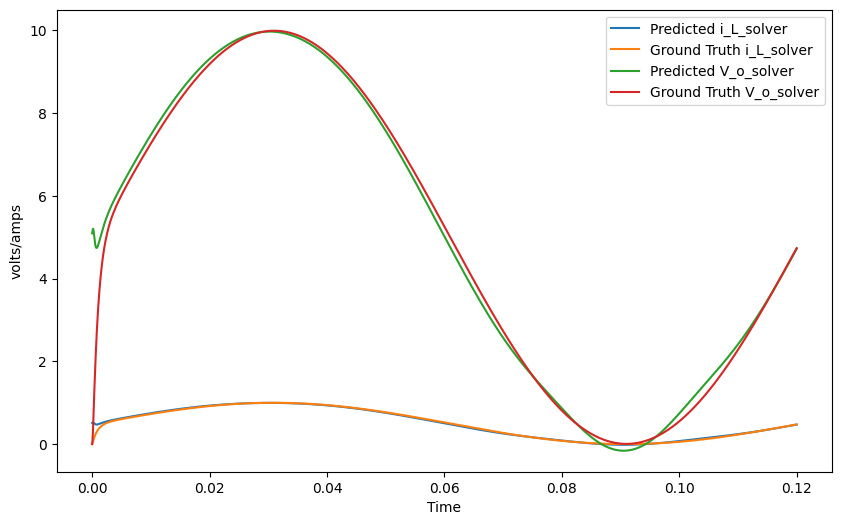

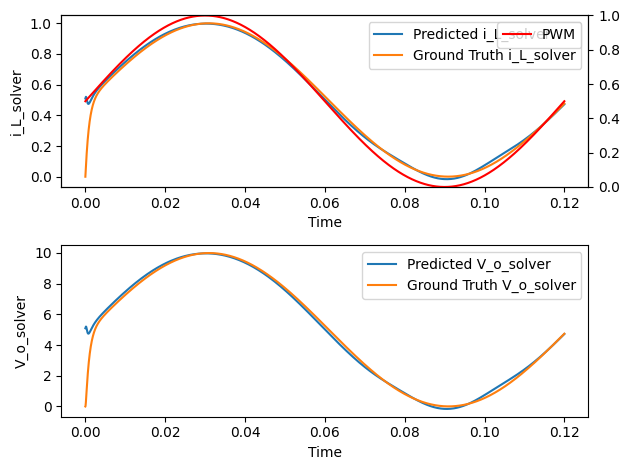

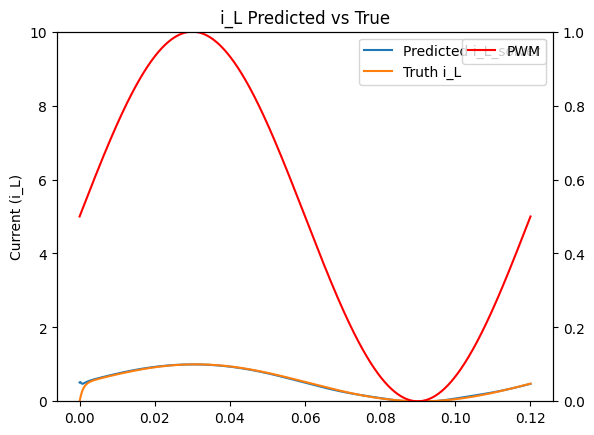

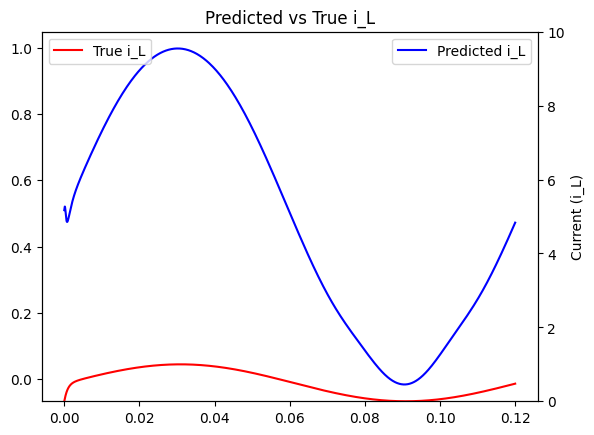

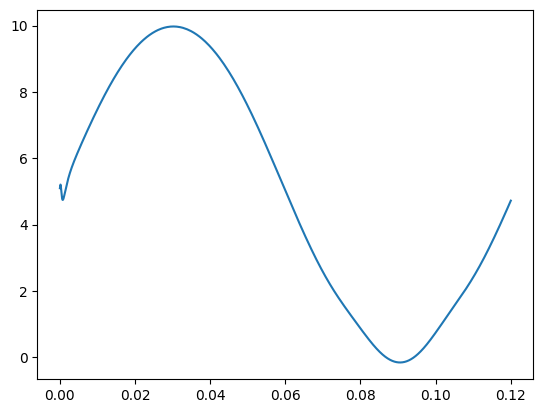

In [18]:
# Plot Results
import matplotlib.pyplot as plt

dataloader = DataLoader(dataset, batch_size=mini_batch_size, shuffle=False)


# Restore the model state
checkpoint = torch.load(f'checkpoint.pth')
model.load_state_dict(checkpoint['model_state_dict'])


# Set the model to evaluation mode
model.eval()

# List to store predicted labels
predicted_labels = []

# Make predictions for the entire dataset
with torch.no_grad():
    for inputs_batch, _ in dataloader:  # We only need the inputs_batch, ignoring the labels
        inputs_batch = inputs_batch.to(device)  # Move inputs to GPU
        predicted_labels_batch = model(inputs_batch)

        predicted_labels.append(predicted_labels_batch.cpu().numpy())


# Concatenate the predicted labels from all batches
predicted_labels = np.concatenate(predicted_labels)

# predicted_labels = output_scaler.inverse_transform(predicted_labels)

# Plot the predictions and ground truth values over time
plt.figure(figsize=(10, 6))




plt.plot(time, predicted_labels[:, 0], label='Predicted i_L_solver')
plt.plot(time, output_labels[:, 0], label='Ground Truth i_L_solver')
# plt.xlabel('Time')
# plt.ylabel('i_L_solver')
plt.plot(time, predicted_labels[:, 1], label='Predicted V_o_solver')
plt.plot(time, output_labels[:, 1], label='Ground Truth V_o_solver')
plt.xlabel('Time')
plt.ylabel('volts/amps')
plt.legend()
plt.show()




# Plot i_L_solver
plt.subplot(2, 1, 1)
plt.plot(time, predicted_labels[:, 0], label='Predicted i_L_solver')
plt.plot(time, output_labels[:, 0], label='Ground Truth i_L_solver')
plt.xlabel('Time')
plt.ylabel('i_L_solver')
plt.legend()
plt.twinx()
plt.plot(time, duty_cycle_data, label='PWM', color='red')
plt.ylim(0, 1)
plt.legend()

# Plot V_o_solver
plt.subplot(2, 1, 2)
plt.plot(time, predicted_labels[:, 1], label='Predicted V_o_solver')
plt.plot(time, output_labels[:, 1], label='Ground Truth V_o_solver')
plt.xlabel('Time')
plt.ylabel('V_o_solver')
plt.legend()

plt.tight_layout()
plt.show()



plt.plot(time, predicted_labels[:, 0], label='Predicted i_L_solver')
# plt.twinx()
plt.plot(time, output_labels[:,0],  label='Truth i_L')
plt.ylabel('Current (i_L)')
plt.ylim(0, 10)
plt.title("i_L Predicted vs True")
plt.legend()
plt.twinx()
plt.plot(time, input_features[:, 0], label='PWM', color='red')
plt.ylim(0, 1)
plt.legend()
plt.show()

plt.plot(time, predicted_labels[:, 0], label='Predicted i_L', color='blue')
plt.legend()
plt.twinx()
plt.plot(time, output_labels[:, 0], label='True i_L', color='red')
plt.ylim(0, 10)
plt.ylabel('Current (i_L)')
plt.title("Predicted vs True i_L")
plt.legend(loc='upper left')
# plt.twinx()
# plt.plot(time, input_features[:, 0], label='PWM', color='red')
# plt.ylim(0, 1)
# plt.legend()
# plt.show()
plt.show()



plt.plot(time, predicted_labels[:, 1], label='Predicted V_o_solver')
plt.show()

Input features shape: torch.Size([120001, 4])
Output labels shape: torch.Size([120001, 2])


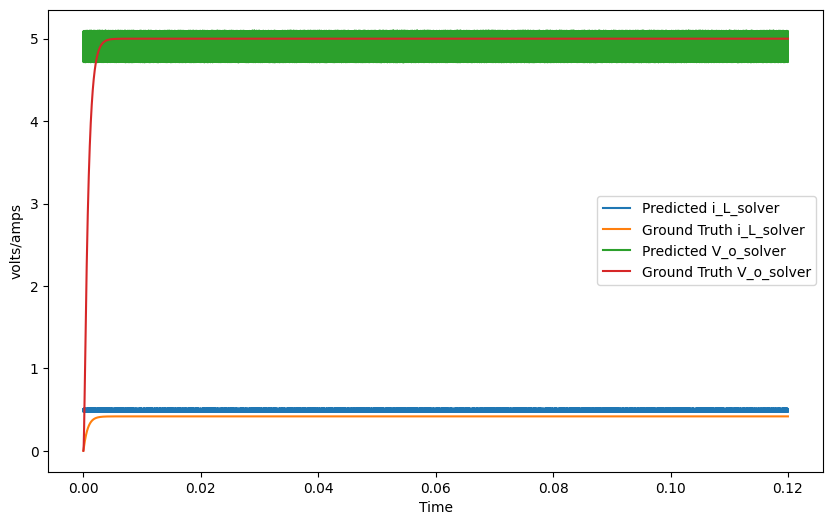

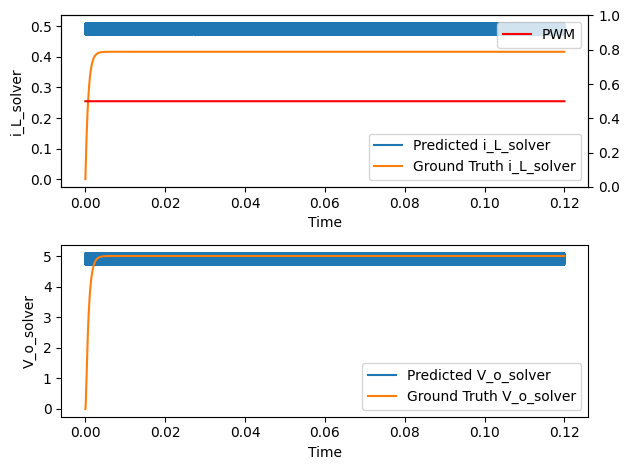

In [19]:
## Now TEST on a different data
### POOR RESULT ###

# Simulation settings
sample_rate = 1e6   # 1 MHz
time_span = 120e-3  # 120 ms
period = 120e-3     # control period (time from .5 to 1 to 0)
pwm_frequency = 1e4 # 10 KHz
# pwm_update_ratio = 1000

# Converter settings
L = 1e-2
C = 1e-5
V_i = 10
R = 12


# PINN settings
epsilon = 1e-6

# time scale
time = np.arange(0, time_span + 1/sample_rate, 1/sample_rate)

# R = (np.sin(2 * np.pi / period * time) + 1) / 2

# Allocate memory
time_length = len(time)
i_L_0 = np.ones(time_length)
V_o_0 = np.ones(time_length)
i_L_solver = np.ones(time_length)
V_o_solver = np.ones(time_length)
d = np.zeros(time_length)




# Timestep
delta_t = 1 / sample_rate

# Stimulus
# duty_cycle = (np.sin(2 * np.pi / period * time) + 1) / 2
duty_cycle = np.full(time_length, 0.5)


# duty_cycle = np.zeros_like(time)
# for i in range(time_length):
#     duty_cycle[i] = 0.5

# Assuming `gen_pwm` is a custom function to generate PWM signals
# You need to implement this function or use an alternative method to generate PWM signals
# pwm_signal = gen_pwm(sample_rate, pwm_frequency, duty_cycle, time)

# Initial conditions
i_L = np.ones_like(time)
V_o = np.ones_like(time)



# time scale
time = np.arange(0, time_span + 1/sample_rate, 1/sample_rate)




R = np.zeros(time_length)
# Set each element of R to the value x using a for loop
for i in range(time_length):
    # R[i] = 12
    R[i] = 12


d = np.full_like(time_length, 0.5)
# #####
# # Make sure we create a duty cycle array of exactly the right length
# quarter_length = time_length // 4  # Use integer division
# remainder = time_length % 4  # Get any remaining points
# # Create base arrays
# duty_cycle_2 = np.full(quarter_length, 1)
# duty_cycle_1 = np.full(quarter_length, 0)
# duty_cycle_4 = np.full(quarter_length, 1)
# duty_cycle_3 = np.full(quarter_length + remainder, 0)  # Add remainder to last segment
# # Concatenate
# duty_cycle = np.concatenate([duty_cycle_1, duty_cycle_2, duty_cycle_3, duty_cycle_4])
# #####




# Simulate with Euler Backwards

# Initialize arrays
i_L_solver = np.zeros_like(time)
V_o_solver = np.zeros_like(time)

# Initialize previous solutions
i_L_0 = np.copy(i_L_solver)
V_o_0 = np.copy(V_o_solver)

# ct = 1

# Implement Euler backward solver
for i in range(1, len(time)):
    # Left-hand side matrix
    # LHS = np.array([[1, delta_t / L], [-delta_t / C, delta_t / (C * R) + 1]])
    LHS = np.array([[1, delta_t / L], [-delta_t / C, delta_t / (C * R[i]) + 1]])
    
    # Right-hand side vector
    RHS = np.array([delta_t * duty_cycle[i] * V_i / L + i_L_solver[i - 1], V_o_solver[i - 1]])
    
    # Solve for the next step
    solved = np.linalg.solve(LHS, RHS)
    i_L_solver[i] = solved[0]
    V_o_solver[i] = solved[1]
    
    # Update initial conditions if PWM signal changes
    if duty_cycle[i] != duty_cycle[i - 1]:
        i_L_0[i] = i_L_solver[i - 1]
        V_o_0[i] = V_o_solver[i - 1]
    else:
        i_L_0[i] = i_L_0[i - 1]
        V_o_0[i] = V_o_0[i - 1]

    # if ct == pwm_update_ratio:
    #     ct = 0
    #     i_L_0[i] = i_L_solver[i - 1]
    #     V_o_0[i] = V_o_solver[i - 1]
    # else:
    #     i_L_0[i] = i_L_0[i - 1]
    #     V_o_0[i] = V_o_0[i - 1]

    # ct += 1

# Set up training data
train_input = np.vstack([duty_cycle, i_L_0, V_o_0, time])
# train_input = np.vstack([i_L_0, V_o_0, time])

# # Plot results for sanity check
# plt.figure()
# plt.plot(time, i_L_solver, label='Euler current')
# plt.plot(time, V_o_solver, label='Euler voltage')
# plt.ylabel('volts/amps')
# plt.xlabel('time (s)')
# plt.legend()
# plt.twinx()
# plt.plot(time, duty_cycle, 'g', label='PWM')
# plt.ylabel('duty cycle')
# plt.ylim(0, 1)
# plt.legend(loc='lower right')
# plt.title('Euler backward solver')
# plt.show()


input_features = train_input.T
output_labels = np.vstack([i_L_solver, V_o_solver]).T



# from sklearn.preprocessing import StandardScaler
# input_scaler = StandardScaler()
# input_normalized = input_scaler.fit_transform(input_features)


# output_scaler = StandardScaler()
# output_normalized = output_scaler.fit_transform(output_labels)




# Convert to PyTorch tensors
inputs = torch.tensor(input_features, dtype=torch.float32)
labels = torch.tensor(output_labels, dtype=torch.float32)

# Check shapes
print("Input features shape:", inputs.shape)
print("Output labels shape:", labels.shape)


# Create DataLoader
dataset = TensorDataset(inputs, labels)
dataloader = DataLoader(dataset, batch_size=mini_batch_size, shuffle=True)


duty_cycle_data = duty_cycle.T





# Set the model to evaluation mode
model.eval()

# List to store predicted labels
predicted_labels = []

# Make predictions for the entire dataset
with torch.no_grad():
    for inputs_batch, _ in dataloader:  # We only need the inputs_batch, ignoring the labels
        inputs_batch = inputs_batch.to(device)  # Move inputs to GPU
        predicted_labels_batch = model(inputs_batch)

        predicted_labels.append(predicted_labels_batch.cpu().numpy())


# Concatenate the predicted labels from all batches
predicted_labels = np.concatenate(predicted_labels)

# predicted_labels = output_scaler.inverse_transform(predicted_labels)

# Plot the predictions and ground truth values over time
plt.figure(figsize=(10, 6))




plt.plot(time, predicted_labels[:, 0], label='Predicted i_L_solver')
plt.plot(time, output_labels[:, 0], label='Ground Truth i_L_solver')
# plt.xlabel('Time')
# plt.ylabel('i_L_solver')
plt.plot(time, predicted_labels[:, 1], label='Predicted V_o_solver')
plt.plot(time, output_labels[:, 1], label='Ground Truth V_o_solver')
plt.xlabel('Time')
plt.ylabel('volts/amps')
plt.legend()
plt.show()


# Plot i_L_solver
plt.subplot(2, 1, 1)
plt.plot(time, predicted_labels[:, 0], label='Predicted i_L_solver')
plt.plot(time, output_labels[:, 0], label='Ground Truth i_L_solver')
plt.xlabel('Time')
plt.ylabel('i_L_solver')
plt.legend()
plt.twinx()
plt.plot(time, duty_cycle_data, label='PWM', color='red')
plt.ylim(0, 1)
plt.legend()

# Plot V_o_solver
plt.subplot(2, 1, 2)
plt.plot(time, predicted_labels[:, 1], label='Predicted V_o_solver')
plt.plot(time, output_labels[:, 1], label='Ground Truth V_o_solver')
plt.xlabel('Time')
plt.ylabel('V_o_solver')
plt.legend()

plt.tight_layout()
plt.show()
